In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torchvision.datasets import MNIST
from random import randrange
from matplotlib import pyplot as plt

In [25]:
torch.manual_seed(0)

In [26]:
loss_function = F.nll_loss
use_gpu = torch.cuda.is_available()
use_gpu

True

In [27]:
# Neural Network Class
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        # Layers for Image Number Prediction
        # input 28 | output 24 | Because of Stride 5
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)

        # input 24 | output 20 | Because of Stride 5
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(in_features=20 * 4 * 4, out_features=50)
        self.out = nn.Linear(in_features=50, out_features=10)

        # Layers for Sum Prediction
        self.sum_fc1 = nn.Linear(in_features=20, out_features=50)
        self.sum_fc2 = nn.Linear(in_features=50, out_features=70)
        self.sum_fc3 = nn.Linear(in_features=70, out_features=40)
        self.sum_out = nn.Linear(in_features=40, out_features=19)


    def forward(self, x, x_int):
        # Processing Image
        x = self.conv1(x) # input image size 28 | output image size 24 | Because of Stride 5
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # input image size 24 | output image size 12 | Because of Maxpooling
        x = F.relu(x) # Output Channels 10


        x = self.conv2(x) # input image size 12 | output image size 8 | Because of Stride 5
        x = self.conv2_drop(x)
        x = F.max_pool2d(x, kernel_size=2,stride=2)   # input image size 8 | output image size 4 | Because of Maxpooling
        x = F.relu(x) # Output Channels 20

        x = x.reshape(-1, 20 * 4 * 4)

        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.log_softmax(F.relu(self.out(x)))

        # Processing Number
        # Getting number predicted by the image network
        num_x = x.data.max(1, keepdim=True)[1]

        # One hot encoding of the number predicted by the image network - 10 classes - 0 to 9
        num_x_one_hot = F.one_hot(num_x.squeeze(), num_classes=10)
        
        # One Hot encoding of input number - 10 classes - 0 to 9
        x_int_one_hot = F.one_hot(x_int, num_classes=10)

        # This condition is required for testing single sample
        if len(num_x_one_hot.shape) == 1:
            num_x_one_hot = num_x_one_hot.unsqueeze(dim=0)

        # Concatnet the one hot encoded image number and input number columnwise - dim=1
        # For batch size of 1000
        # One hot encoded image number shape 1000 x 10
        # One hot encoded input number shape 1000 x 10

        sum_t = torch.cat((num_x_one_hot,x_int_one_hot), dim=1).float()
        # After concatenation - 1000 x 20

        # Now take channels from 20 -> 50 -> 70 -> 40 -> 19
        # Final channels are 19 - as the maximum sum can be 9 + 9 = 18
        sum_t = F.relu(self.sum_fc1(sum_t))
        sum_t = F.dropout(F.relu(self.sum_fc2(sum_t)), training=self.training)
        sum_t = F.dropout(F.relu(self.sum_fc3(sum_t)), training=self.training)
        sum_t = F.log_softmax(F.relu(self.sum_out(sum_t)))

        # Returning processed image and number 
        return x,sum_t

In [28]:
# Custom dataloader combining image and a random number
# Inherits from MNIST
# We need to override only __getitem__ to return a random number along with an image
class MNISTPlusDataset(MNIST):
    def __getitem__(self, index):
        # User parent class __getitem__ method to get an image
        item = super(MNISTPlusDataset, self).__getitem__(index)

        # Generate random int 0 to 9
        random_int = torch.tensor(randrange(10))

        # return tuple with following 
        # x :  a tuple, image and a random number
        # y : a tuple, true image lable and random number + true image number 
        return (
            (item[0], random_int),
            (item[1],random_int + item[1])
        )

In [29]:
# Custom loss function
# Combines loss from image and sum processing
# Returns average loss
def custom_loss(x_output,y,x_sum_output,y_sum):
    loss_x = loss_function(x_output,y)
    loss_y_sum = loss_function(x_sum_output, y_sum)
    return (loss_x + loss_y_sum)/2

In [30]:
train_losses = []
test_losses = []
train_counter = []
log_interval = 10

In [31]:
# Train function. This runs single epoch.
# Inputs -
# network - Network class object
# train_loader - Custom train loader
# optimizer - optimizer object
# epoc - epoc number
def train(network, train_loader, optimizer, epoch):
    # Turn on the training mode - enables gradient
    network.train()

    for batch_idx, (image, target) in enumerate(train_loader):
        # Initialize gradients to zero
        optimizer.zero_grad()

        # image and targets are tuples as mentioned in custom dataloader class
        output, output_sum = network(image[0], image[1])
        loss = custom_loss(output, target[0],output_sum,target[1])
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(image[0]), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.item()))
                # Preserve loss for plotting
                train_losses.append(loss.item())
                train_counter.append(
                    (batch_idx * 64) + ((epoch - 1) * len(train_loader.dataset)))
      

In [32]:
def test(network, test_loader):    
    network.eval()
    test_loss = 0
    correct = 0
    correct_sum = 0
    with torch.no_grad():
        for image, target in test_loader:
            output, output_sum = network(image[0], image[1])
            loss = custom_loss(output, target[0], output_sum, target[1])
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            pred_sum = output_sum.data.max(1, keepdim=True)[1]
            correct += pred.eq(target[0].data.view_as(pred)).sum()
            correct_sum += pred_sum.eq(target[1].data.view_as(pred_sum)).sum()

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)
        print('\nTest set: Avg. loss: {:.4f}, Accuracy Image: {}/{} ({:.0f}%) , Accuracy Sum: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset), correct_sum,len(test_loader.dataset), 100. * correct_sum / len(test_loader.dataset)))

In [33]:
def plot_loss():
    fig = plt.figure()
    plt.plot(train_counter, train_losses, color='blue')
    #plt.scatter(test_counter, test_losses, color='red')
    plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
    plt.xlabel('number of training examples seen')
    plt.ylabel('negative log likelihood loss')
    plt.show()


In [34]:
# Runs sample inputs to show that output
def run_some_samples(network,test_loader,num_samples):
    for i in range(num_samples):
        image = next(iter(test_loader))
        output, output_sum = network(image[0][0][i].unsqueeze(dim=0), image[0][1][i].unsqueeze(dim=0))
        print(f"Image Predicted:{torch.argmax(output.squeeze()).item()}, Image Actual:{image[1][0][i].item()},Random Input Number:{image[0][1][i].item()},Sum Precicted:{torch.argmax(output_sum.squeeze()).item()}, Sum Actual:{image[1][1][i]}")


In [35]:
network = Network()
n_epochs = 2
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01

In [36]:
train_loader = torch.utils.data.DataLoader(
        MNISTPlusDataset('/files/', train=True, download=True,
                                   transform=torchvision.transforms.Compose([
                                       torchvision.transforms.ToTensor(),
                                       torchvision.transforms.Normalize(
                                           (0.1307,), (0.3081,))
                                   ])),
        batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    MNISTPlusDataset('/files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                        (0.1307,), (0.3081,))
                                ])),
    batch_size=batch_size_test, shuffle=True)

In [37]:
test_counter = [i * len(train_loader.dataset) for i in range(n_epochs + 1)]
optimizer = optim.Adam(network.parameters(),lr=learning_rate)
test(network, test_loader)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.0026, Accuracy Image: 767/10000 (8%) , Accuracy Sum: 881/10000 (9%)



In [38]:
for epoch in range(1, n_epochs + 1):
    train(network, train_loader, optimizer, epoch)
    test(network, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.622727


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [640/60000 (1%)]	Loss: 2.601291
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.579573
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.499271
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.434573
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.280845
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.241239
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.197711
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.196783
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.987944
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.103459
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.836078
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.922453
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.950262
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.847073
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.682628
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.534135
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.679816
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.616724
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.684713
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.659285
Train Epoch: 1 [13440/60

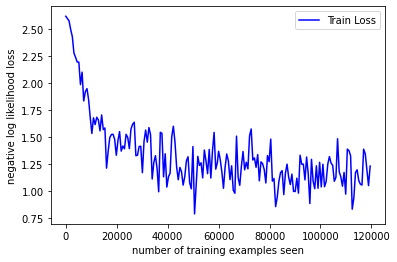

In [39]:
plot_loss()

In [40]:
run_some_samples(network,test_loader,10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:67: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Image Predicted:3, Image Actual:3,Random Input Number:8,Sum Precicted:11, Sum Actual:11
Image Predicted:1, Image Actual:1,Random Input Number:3,Sum Precicted:4, Sum Actual:4
Image Predicted:0, Image Actual:0,Random Input Number:4,Sum Precicted:4, Sum Actual:4
Image Predicted:1, Image Actual:1,Random Input Number:2,Sum Precicted:0, Sum Actual:3
Image Predicted:0, Image Actual:0,Random Input Number:7,Sum Precicted:7, Sum Actual:7
Image Predicted:7, Image Actual:7,Random Input Number:6,Sum Precicted:0, Sum Actual:13
Image Predicted:4, Image Actual:4,Random Input Number:7,Sum Precicted:11, Sum Actual:11
Image Predicted:1, Image Actual:1,Random Input Number:9,Sum Precicted:10, Sum Actual:10
Image Predicted:1, Image Actual:1,Random Input Number:5,Sum Precicted:6, Sum Actual:6
Image Predicted:2, Image Actual:2,Random Input Number:2,Sum Precicted:4, Sum Actual:4
